# spo2 calibration
hold breath to obtain low level oxygen

## import module and declare function

In [8]:

import numpy as np
import matplotlib.pyplot as plt
import os,sys
import scipy.signal as signal
from scipy.interpolate import interp1d
import re
import pandas as pd
import math
plt.style.use('ggplot')
sys.path.insert(0, os.path.abspath('../lib'))

import sig_proc as sp
import file_read

import csv

# Normalize to mv
def value_trans(data):
    data = data*1.2/2097151.0
    return data


def RMS_amp(data):
    squaredData = []
    for val in data:
        squaredData.append(val**2)
    
    ms = np.mean(squaredData)
    rms = math.sqrt(ms)
    return rms


def sqi_xcorr(x,y):
    x_norm = sp.z_score(x)
    y_norm = sp.z_score(y)
    pxy = max(np.correlate(x_norm, y_norm))
#     pyy = np.correlate(y_norm, y_norm)
    pyy = sum(y_norm*y_norm)
    return (2*pxy)/pyy


def ppg_proc(df, index, sr=50, source='RawData'):
    global bp_a, bp_b
    
    for i in index:
        subject = df.loc[i]['subject']
        data = file_read.thor2_reader(os.path.join("../../data", folder, subject), source)

        R = np.array(data['PPG_R'])
        IR = np.array(data['PPG_IR'])
        G = np.array(data['PPG_G2'])

        
        s1 = df.loc[i]['t1']*sr
        s2 = s1+6*sr
        IR_segment = np.array(IR[s1:s2])
        R_segment = np.array(R[s1:s2])
        G_segment = np.array(G[s1:s2])
        
        filt_IR = signal.filtfilt(bp_b,bp_a, IR_segment)
        filt_R = signal.filtfilt(bp_b, bp_a, R_segment)
        filt_G = signal.filtfilt(bp_b, bp_a, G_segment)
        
        R_AC = RMS_amp(filt_R)
        IR_AC = RMS_amp(filt_IR)
        
        plt.figure(figsize=(6,4))

        plt.axhline(R_AC, color='r', linestyle='--')
        plt.axhline(IR_AC, color='blue', linestyle='--')
        plot_title = "{}, {} \n".format(subject, df.loc[i]['t1'])
        plot_title = plot_title + "R-value: {}\n".format(np.round(df.loc[i]['R_value'],2))
        plt.title(plot_title)
        plt.plot(filt_R, label='R')
        plt.plot(filt_IR, label='IR')
        plt.plot(filt_G, label='G')
        plt.legend()

    

## Main function

In [2]:
# folder = "SPO2/Tho2 2.0 Pi & SPO2 0525"
# folder = "SPO2/Thor 2.0 SPO2 0601"
# subjects = ['Coco', 'Gary', 'Jason', 'Nicole', 'Shawn', 'Tanya', 'Steven']
# subjects = ['Tanya']


# folder= "SPO2/Jing0603"
# subjects = ['01', '02', '03']

folder = "SPO2/高山"
subjects = ["2022-7-23_18-46-26_T2-03-d72e2b_RawData_Nicole.csv", "2022-7-23_19-1-6_T2-03-d72e2b_RawData_Jet.csv"]

''' Select the duration of PPG segment in seconds'''
start_sec = 0
period = 6
overlap = 4
# overlap = 0
# data_length = len(G_y)/sr
hop_length = period - overlap
# num_watching_period = 200


# data_length = len(data['PPG_G'])
# num_watching_period = int((data_length - overlap)/hop_length) -1

vsTable = {
    'subject':[],
    't1':[],
    'spo2':[],
    'R_AC':[],
    'R_DC':[],
    'IR_AC':[],
    'IR_DC':[],
    'G_AC':[],
    'G_DC':[],
    'R_PI':[],
    'IR_PI':[],
    'G_PI':[],
    'R_value':[],
    'R_squared':[],
}

# K1 = 121.12
# K2 = -51.77
K1 = 99.813
K2 = -4.615

sr = 50

# Filter parameters
bp_b, bp_a = sp.bp_filter(0.8, 3, sr, 4)
lp_b, lp_a = sp.lp_filter(3, sr, 4)

coeficient = [-12.75886139, 1.39192419]
intercept = 104.14801275562009
for subject in subjects:
    # full_path = os.path.join("../../data", folder, subject)
    # data = file_read.thor2_reader(os.path.join("../../data", folder, subject), 'RawData')
    data = file_read.thor2_reader(os.path.join("../../data", folder, subject))
    # R = file_read.load_ppg(full_path, 'PPG_R')
    # IR = file_read.load_ppg(full_path, 'PPG_IR')
    # G = file_read.load_ppg(full_path, 'PPG_G')
    R = np.array(data['PPG_R'])
    IR = np.array(data['PPG_IR'])
    G = np.array(data['PPG_G2'])
    
    
    # R = np.array(list(map(value_trans, R)))
    # IR = np.array(list(map(value_trans, IR)))
    # G = np.array(list(map(value_trans, G)))

    
    
    data_length = len(G)/sr
    num_watching_period = int((data_length - start_sec -overlap)/hop_length) -1
    # num_watching_period = 10
    for n in range(num_watching_period):
        

        t1 = start_sec +  (period-overlap) * n
        t2 = t1 + period
        s1 = int(t1*sr)
        s2 = int(t2*sr )

        '''''''''''''''''''''''''''''''''''''''
        Signal Preprocessing
        '''''''''''''''''''''''''''''''''''''''
        IR_segment = np.array(IR[s1:s2])
        R_segment = np.array(R[s1:s2])
        G_segment = np.array(G[s1:s2])
        
        ''' AC component '''
        filt_IR = signal.filtfilt(bp_b,bp_a, IR_segment)
        filt_R = signal.filtfilt(bp_b, bp_a, R_segment)
        filt_G = signal.filtfilt(bp_b, bp_a, G_segment)
        ''' DC component '''
        R_DC_component = signal.filtfilt(lp_b,lp_a, R_segment)
        IR_DC_component = signal.filtfilt(lp_b,lp_a, IR_segment)
        G_DC_component = signal.filtfilt(lp_b,lp_a, G_segment)

        ''' signal quality '''
        # level = signalQuality(filt_R, filt_IR, sr)
        
        ''' Calculate R value by using RMS method'''
        R_AC = RMS_amp(filt_R)
        R_DC = RMS_amp(R_DC_component)
        IR_AC = RMS_amp(filt_IR)
        IR_DC = RMS_amp(IR_DC_component)
        
        G_AC = RMS_amp(filt_G)
        G_DC = RMS_amp(G_DC_component)
        
   
        
        R_ratio = RMS_amp(filt_R/R_DC_component)
        IR_ratio = RMS_amp(filt_IR/IR_DC_component)
        G_ratio = RMS_amp(filt_G/G_DC_component)
    
        
        # R_divide = filt_R/R_DC_component
        # R_RMS = RMS_amp(R_divide)

        # IR_divide = filt_IR/IR_DC_component
        # IR_RMS = RMS_amp(IR_divide)
        
        R_value = R_ratio/ IR_ratio
        R_squared = R_value**2
        
        # coeficient = [ 17.41863831, -18.27211895]
        # intercept = 94.81588110236386

        spo2 = intercept + (coeficient[0]*R_value) + (coeficient[1]*R_squared)

        # simulator
        # spo2 = 119.4638 + (-37.8709*R_value) + (-0.1610*R_squared)
        
        vsTable['subject'].append(subject)
        vsTable['t1'].append(t1)
        vsTable['spo2'].append(spo2)
        vsTable['R_AC'].append(R_AC)
        vsTable['R_DC'].append(R_DC)
        vsTable['IR_AC'].append(IR_AC)
        vsTable['IR_DC'].append(IR_DC)
        vsTable['G_AC'].append(G_AC)
        vsTable['G_DC'].append(G_DC)
        
        vsTable['R_PI'].append(R_ratio*100)
        vsTable['IR_PI'].append(IR_ratio*100)
        vsTable['G_PI'].append(G_ratio*100)
        vsTable['R_value'].append(R_value)
        vsTable['R_squared'].append(R_squared)
        
        '''''''''''''''''''''''''''''''''''
        plot filgure
        '''''''''''''''''''''''''''''''''''
        # font_size = 14
        # fig_size  = (6,4)
        
        # plt.figure(figsize=fig_size)
        # plot_title = "{},{}:{} \n".format(subject, t1,t2)
        # plot_title = plot_title + "R value: {}\n".format(np.round(R_value,4))
        # plt.title(plot_title)
        # plt.plot(filt_R, label='R')        
        # plt.plot(filt_IR, label='IR')
        
        # plt.axhline(R_AC, color='r', linestyle='--')
        # plt.axhline(IR_AC, color='blue', linestyle='--')

        # # plt.plot(filt_G, label='G')

        # plt.legend()

    # plt.figure()
    # plt.title('{}, spo2:{}'.format(subject, int(spo2_value+0.5)))
    # x = np.arange(2)
    # width = 0.3
    # plt.bar(x,[R_RMS, IR_RMS], width, bottom=None, align='center',
    #         color=['#E24A33', '#348ABD' ])
    # plt.xticks(x, ['R', 'IR'], fontsize=12)
    # plt.xlabel('LED')
    # plt.ylabel('PI')




## Distribution of Rvalue

In [3]:
import pandas as pd
df = pd.DataFrame(vsTable)
df.head()


,subject,t1,spo2,R_AC,R_DC,IR_AC,IR_DC,G_AC,G_DC,R_PI,IR_PI,G_PI,R_value,R_squared
0,2022-7-23_18-46-26_T2-03-d72e2b_RawData_Nicole...,0,95.404519,133.177491,1.214389e+06,202.816941,1.380027e+06,435.445859,1.241378e+06,0.010969,0.014704,0.035074,0.746001,0.556518
1,2022-7-23_18-46-26_T2-03-d72e2b_RawData_Nicole...,2,95.111706,140.031330,1.215937e+06,205.692505,1.381346e+06,399.900470,1.244410e+06,0.011528,0.014903,0.032153,0.773511,0.598320
2,2022-7-23_18-46-26_T2-03-d72e2b_RawData_Nicole...,4,96.327110,104.698968,1.217713e+06,180.072573,1.383120e+06,412.910684,1.251289e+06,0.008608,0.013030,0.033037,0.660584,0.436371
3,2022-7-23_18-46-26_T2-03-d72e2b_RawData_Nicole...,6,96.964271,76.331142,1.218830e+06,143.897173,1.384403e+06,410.403739,1.258042e+06,0.006264,0.010394,0.032609,0.602663,0.363203
4,2022-7-23_18-46-26_T2-03-d72e2b_RawData_Nicole...,8,97.625664,86.597136,1.219037e+06,181.119102,1.385252e+06,425.628709,1.261818e+06,0.007104,0.013073,0.033724,0.543417,0.295302


## Select specific target to observe

Text(0, 0.5, 'R value')

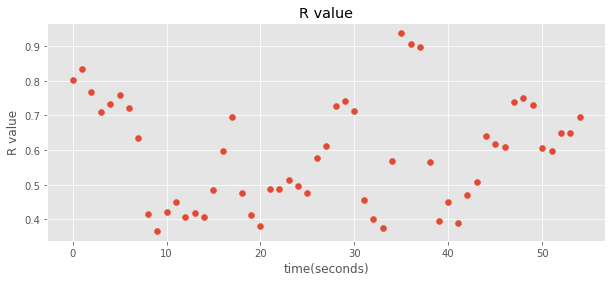

In [28]:
# ppg_proc(df, df.index[30:50])

tartgetSub = subjects[1]
subjectDF = df[df.subject ==tartgetSub]
plt.figure(figsize=(10,4))
plt.title('R value')
plt.scatter(np.arange(len(subjectDF.R_value)), subjectDF.R_value)

# plt.scatter(subjectDF.t1, subjectDF.R_value)

plt.xlabel('time(seconds)')
plt.ylabel('R value')


(92.0, 100.0)

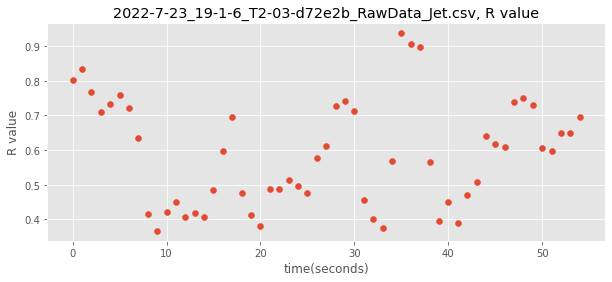

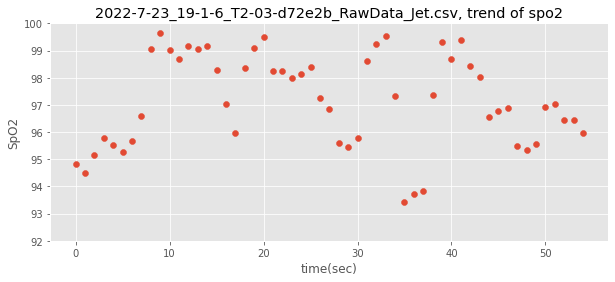

In [31]:


plt.figure(figsize=(10,4))
plt.title(tartgetSub + ', R value')
plt.scatter(np.arange(len(subjectDF.R_value)), subjectDF.R_value)

# plt.scatter(subjectDF.t1, subjectDF.R_value)

plt.xlabel('time(seconds)')
plt.ylabel('R value')
# plt.scatter(subjectDF.R_value, subjectDF.spo2)

# du = 5 # delay unit
# l = len(subjectDF.R_value)
# stable_spo2 = np.array([100 for s in range(l-du)])
# times = np.zeros(l-du)
# for i in range(du, len(stable_spo2)):
#     times[i-du] = start_sec + i*2
#     if np.std(subjectDF.R_value[i-du:i]) < 0.08:
#         stable_spo2[i-du] = subjectDF.spo2[i]
#     else:
#         stable_spo2[i-du] = stable_spo2[max(0, i-du-1)]

plt.figure(figsize=(10,4))
plt.title(tartgetSub + ', trend of spo2')
plt.scatter(np.arange(len(subjectDF.spo2)), subjectDF.spo2)
plt.xlabel('time(sec)')
plt.ylabel('SpO2')
plt.ylim(92, 100)
# plt.savefig('0525_' + subject + '_spo2.png')

# plt.figure(figsize=(10,4))
# plt.title(tartgetSub + ', trend of spo2 with post processing')
# plt.scatter(times, stable_spo2)
# plt.xlabel('time(sec)')
# plt.ylabel('SpO2')
# plt.savefig('0525_' + subject + '_spo2_post.png')


# test_R = 1.6
# test_R_squared = test_R**2
# print(intercept + (coeficient[0]*test_R) + (coeficient[1]*test_R_squared))



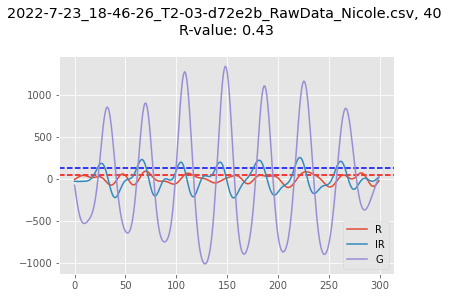

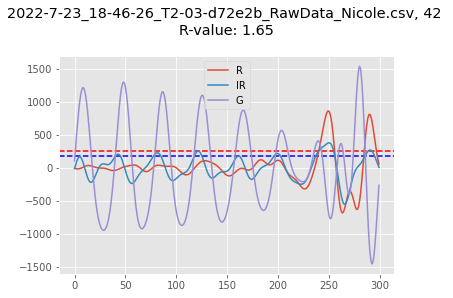

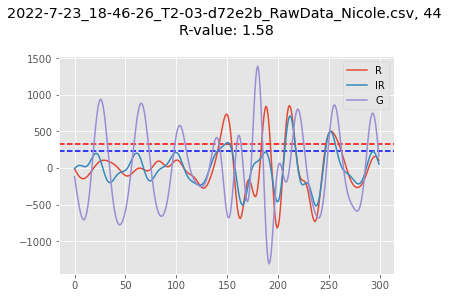

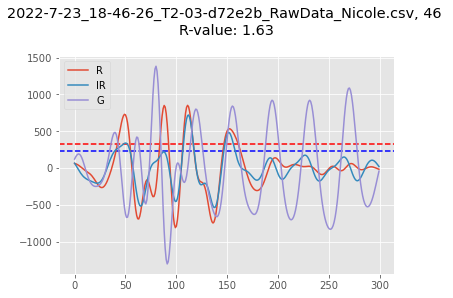

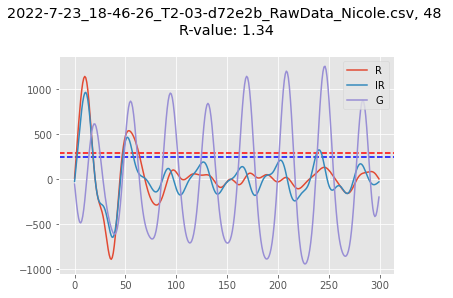

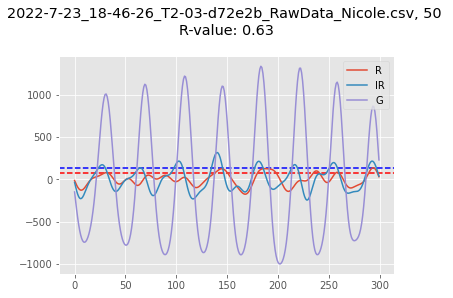

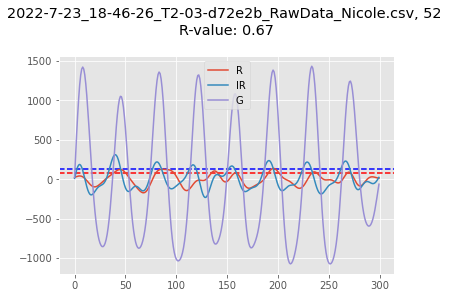

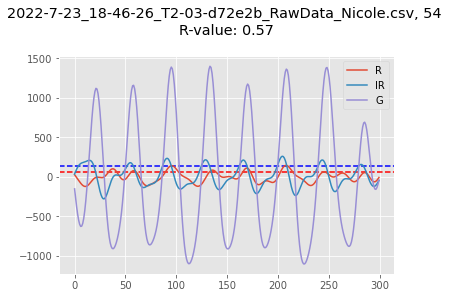

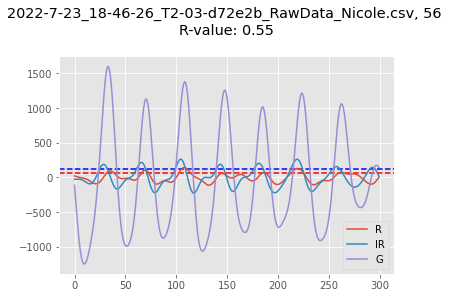

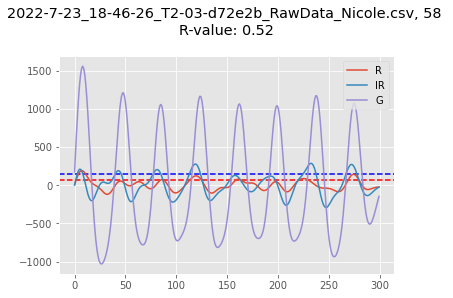

In [14]:
ppg_proc(subjectDF, [i for i in range(20,30)], source=None)

## Check AC and DC component 

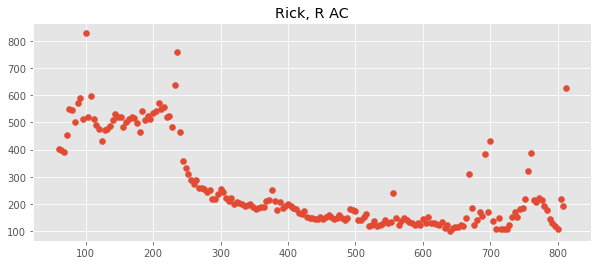

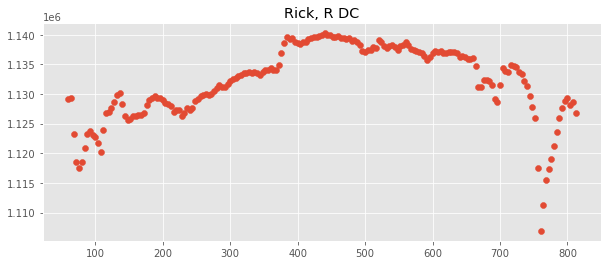

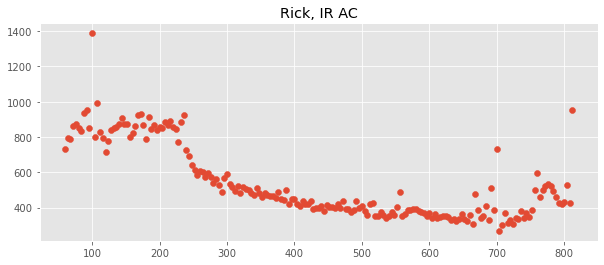

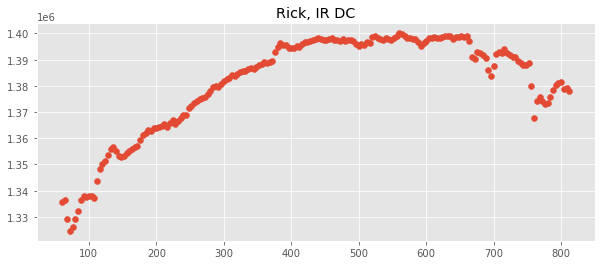

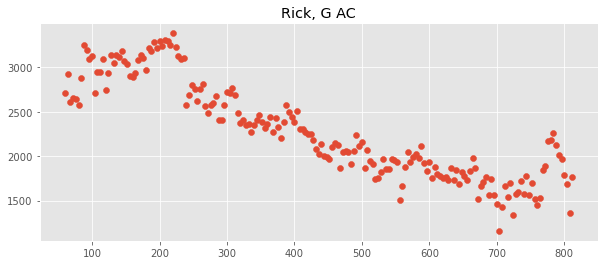

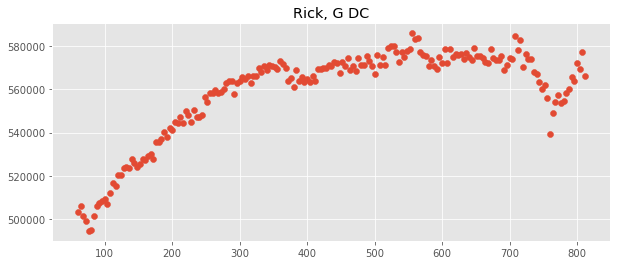

In [37]:
plt.figure(figsize=(10,4))
plt.title(df.subject[0]+', R AC')
plt.scatter(df.t1, df.R_AC)

plt.figure(figsize=(10,4))
plt.title(df.subject[0]+', R DC')
plt.scatter(df.t1, df.R_DC)

plt.figure(figsize=(10,4))
plt.title(df.subject[0]+', IR AC')
plt.scatter(df.t1, df.IR_AC)

plt.figure(figsize=(10,4))
plt.title(df.subject[0]+', IR DC')
plt.scatter(df.t1, df.IR_DC)


plt.figure(figsize=(10,4))
plt.title(df.subject[0]+', G AC')
plt.scatter(df.t1, df.G_AC)
plt.figure(figsize=(10,4))
plt.title(df.subject[0]+', G DC')
plt.scatter(df.t1, df.G_DC)


## Calibration 

In [ ]:
valid_spo2 = [91, 91,91, 97, 97, 97, 98, 96, 94, 91, 
              96, 95, 95, 94, 93, 91, 91, 97,97, 96, 
              96, 96, 95, 94, 95, 94, 93, 92, 91, 92, 
              91, 91, 91, 96,96, 97, 98, 98, 98, 98, 
              99, 99, 99, 99, 99, 98]
valid_R = [1.26, 1.11,1.05, 0.6, 0.63, 0.65, 0.58, 0.68, 0.87, 1.17, 
           0.7, 0.8, 0.81, 0.87, 0.96, 1.08, 1.13, 0.59,0.63, 0.68,
           0.72, 0.73, 0.78, 0.85, 0.79, 0.9, 0.97, 1.1, 1.2, 1.08, 
           1.21, 1.28, 1.18, 0.71, 0.67, 0.62, 0.55, 0.51, 0.5, 0.49, 
           0.41, 0.44, 0.38, 0.39, 0.42, 0.47]

print(len(valid_spo2), len(valid_R))

## PI distribution

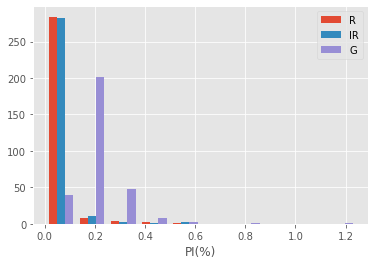

In [112]:
plt.hist([df.R_PI, df.IR_PI, df.G_PI], density=False, cumulative = False, label=['R', 'IR', 'G'])
plt.legend()
plt.xlabel('PI(%)')
plt.show()

[array([0.64229195, 0.64229195, 0.90122601, 0.90122601, 0.64229195])]
Q1: [0.64]
Q3: [0.9]


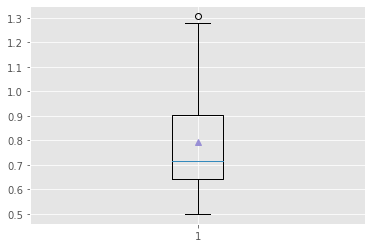

In [15]:
bp = plt.boxplot(df.R_value, showmeans=True)
# df.boxplot(column='R_value')
print([item.get_ydata() for item in bp['boxes']])

q1 = [round(min(item.get_ydata()), 2) for item in bp['boxes']]
q3 = [round(max(item.get_ydata()), 2) for item in bp['boxes']]
print(f'Q1: {q1}\n'
      f'Q3: {q3}')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


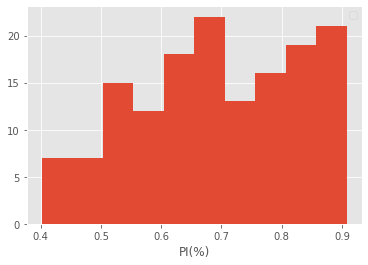

In [117]:
df_inRange = df.loc[(df['R_value']> q1[0]) & (df['R_value']< q3[0])]
df_outRange = df.loc[(df['R_value']< q1[0]) | (df['R_value']> q3[0])]



plt.hist(df_inRange.R_value, density=False, cumulative = False)
plt.legend()
plt.xlabel('PI(%)')
plt.show()

Text(0, 0.5, 'G PI')

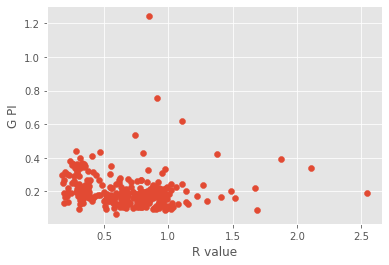

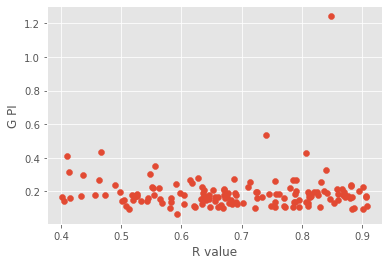

In [116]:
plt.scatter(df.R_value, df.G_PI)
plt.xlabel("R value")
plt.ylabel("G PI")


plt.figure()
plt.scatter(df_inRange.R_value, df_inRange.G_PI)
plt.xlabel("R value")
plt.ylabel("G PI")
# ppg_proc(df_outRange, df_outRange.index[-20:-1])